In [1]:
import json

import pandas
import seaborn

In [2]:
dataset_long = pandas.read_parquet("reports/dataset.long.parquet")
dataset_long

dimension  response
segment         id model       persona                      
descriptiveness 1  llama3.1:8b Argentina      care       5.0
                               Argentina      care       5.0
                               Argentina      care       5.0
                               Argentina      care       5.0
                               Argentina      care       5.0
...                                            ...       ...
                36 qwen2.5:7b  UAE          purity       3.0
                               UAE          purity       3.0
                               UAE          purity       3.0
                               UAE          purity       3.0
                               UAE          purity       3.0

[166255 rows x 2 columns]

In [8]:
dataset_long_human = (
    pandas.DataFrame(json.load(open("../../data/moral_foundations_2/surveys.json"))["atari_et_al"]["country"])
    .T
    .melt(ignore_index=False)
    .reset_index()
    .rename(columns={
        "index": "persona",
        "variable": "dimension",
        "value": "response",
    })
    .assign(model="human")
)
dataset_long_human

,persona,dimension,response,model
0,Argentina,care,3.84,human
1,Belgium,care,3.91,human
2,Chile,care,3.77,human
3,Colombia,care,3.83,human
4,Egypt,care,4.38,human
...,...,...,...,...
109,Russia,purity,3.25,human
110,Saudi Arabia,purity,3.98,human
111,South Africa,purity,3.40,human
112,Switzerland,purity,2.95,human


In [9]:
df_prep = (
    dataset_long
    .groupby(["model", "persona", "dimension"], observed=True)
    ["response"]
    .agg("mean")
    .reset_index()
    .pipe(lambda _df: pandas.concat([dataset_long_human, _df], ignore_index=True))
    .pipe(
        lambda _df: _df.assign(dimension_projection=pandas.Series(pandas.factorize(_df["dimension"])[0]) * 60)
    )
)
df_prep

,persona,dimension,response,model,dimension_projection
0,Argentina,care,3.840000,human,0
1,Belgium,care,3.910000,human,0
2,Chile,care,3.770000,human,0
3,Colombia,care,3.830000,human,0
4,Egypt,care,4.380000,human,0
...,...,...,...,...,...
793,UAE,care,4.367893,qwen2.5:7b,0
794,UAE,equality,3.088435,qwen2.5:7b,60
795,UAE,loyalty,3.738255,qwen2.5:7b,180
796,UAE,proportionality,3.942568,qwen2.5:7b,120


/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


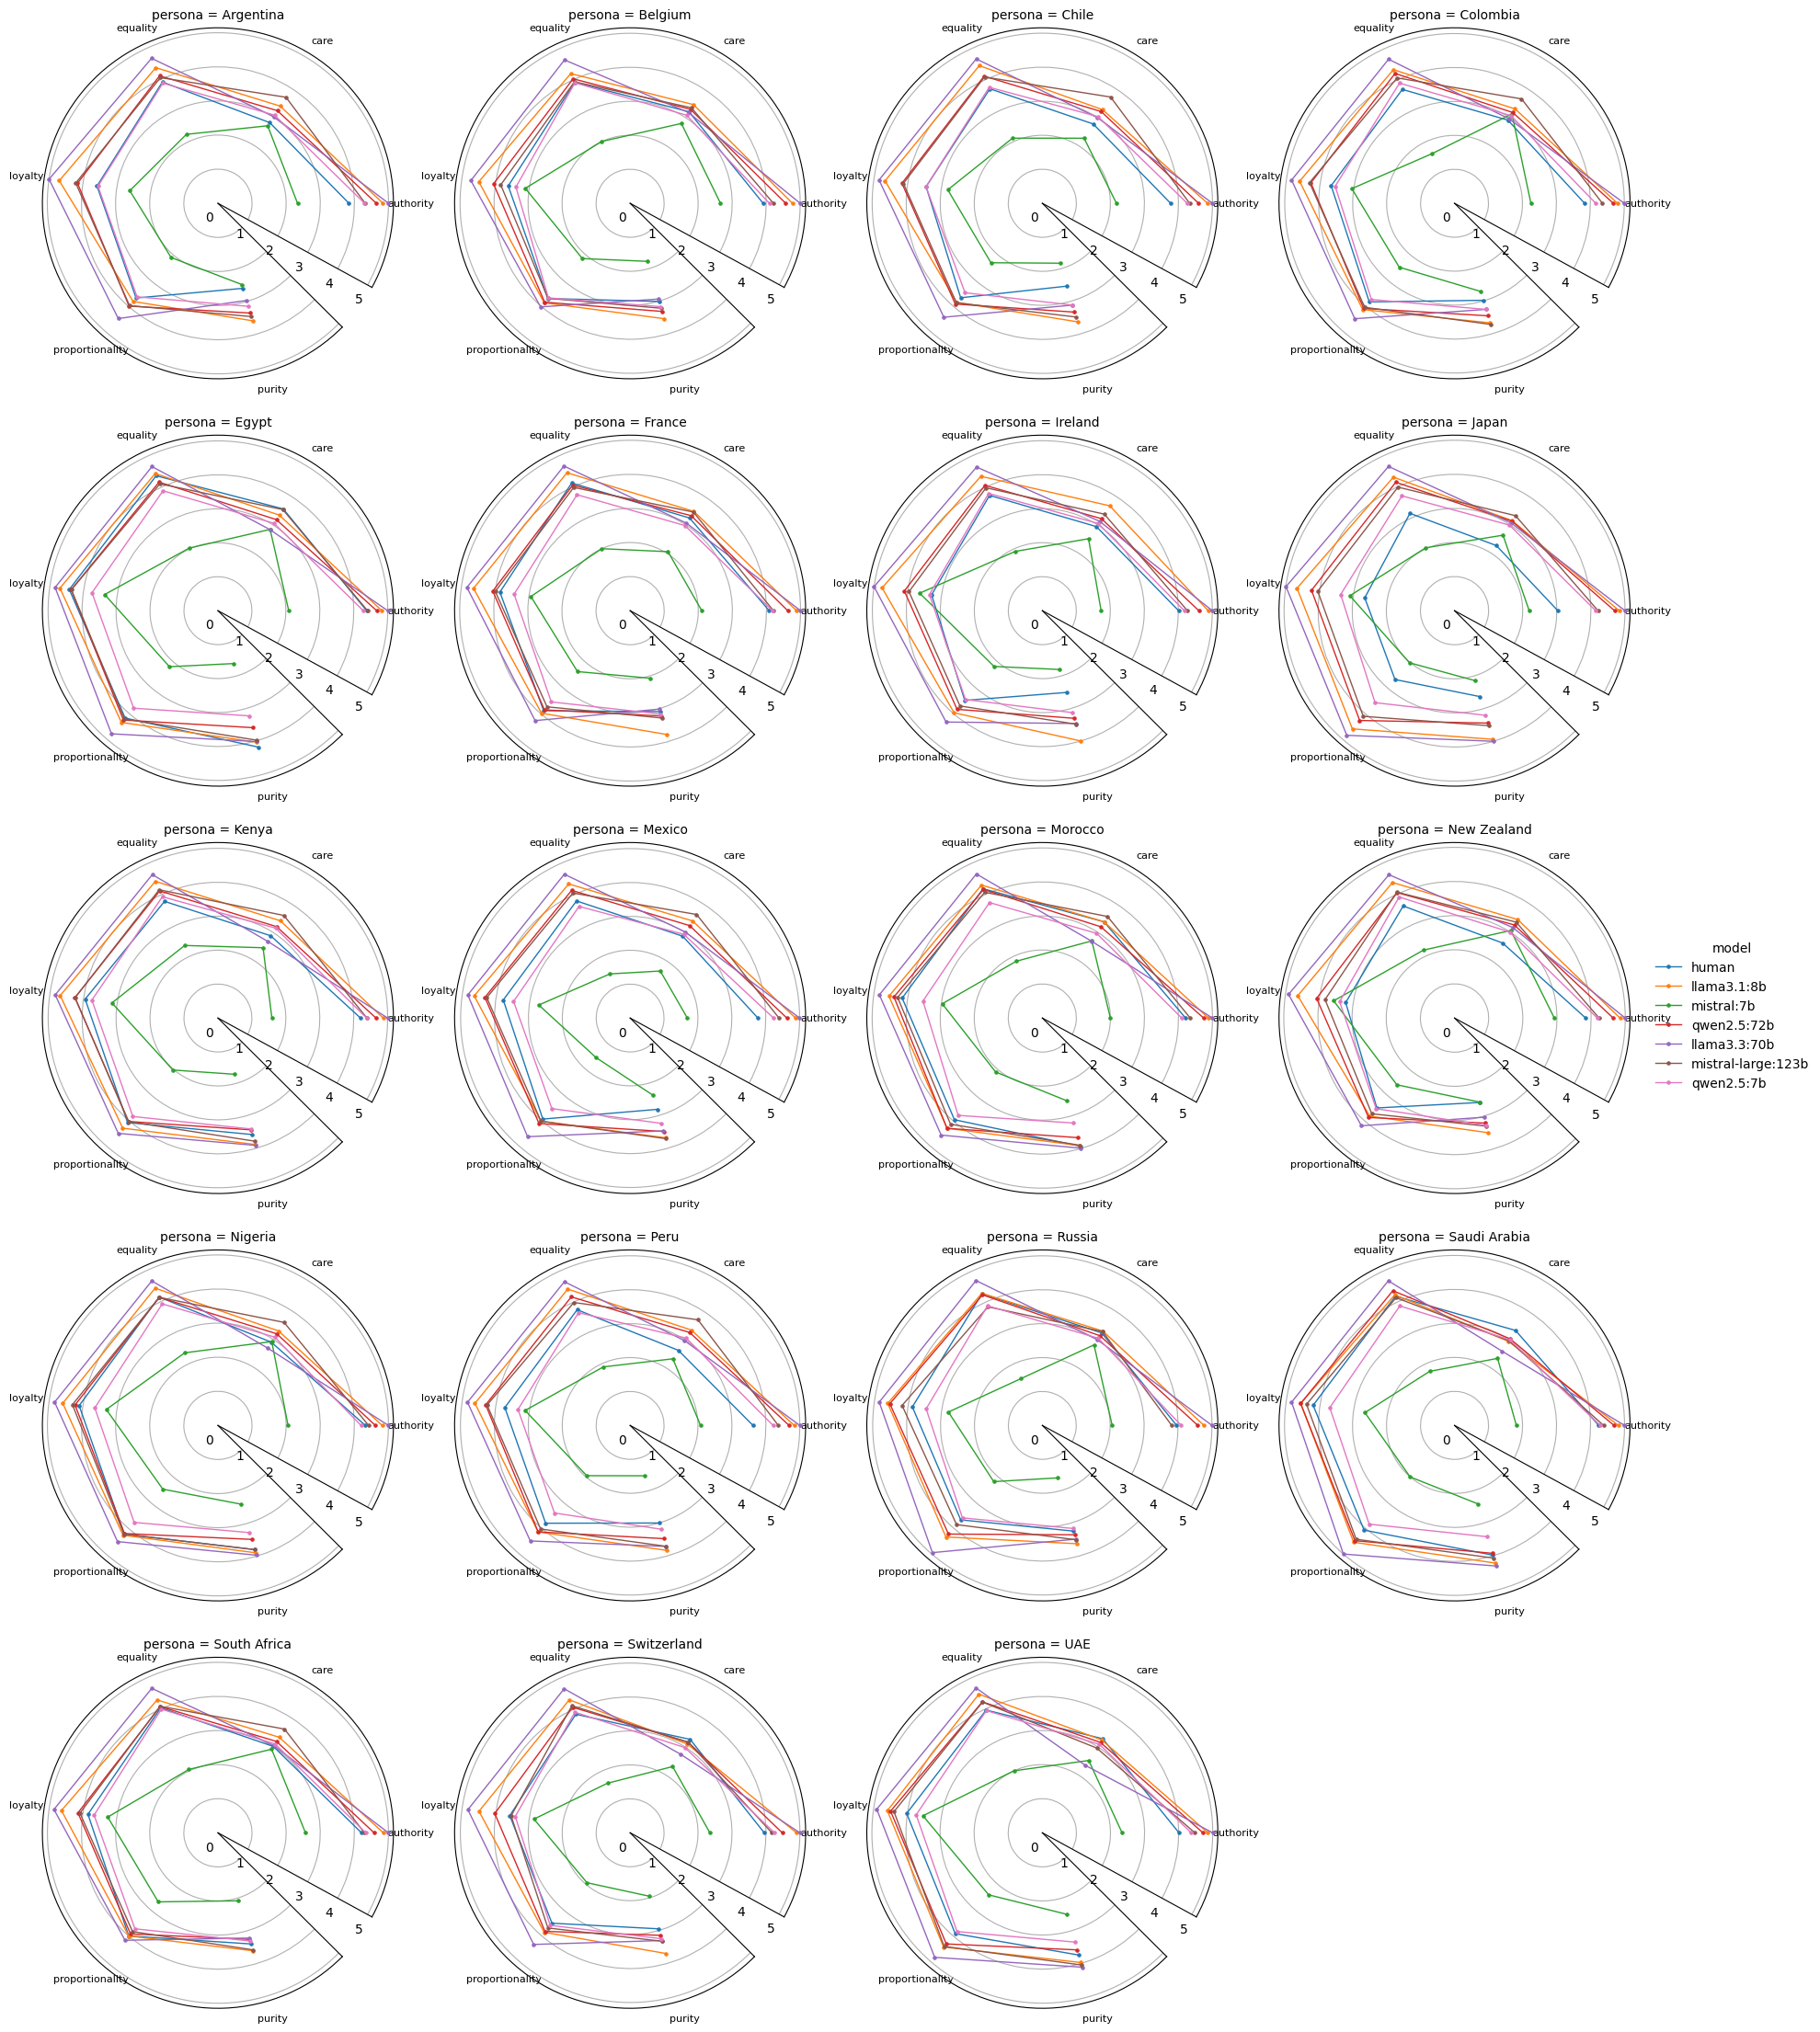

In [10]:
grid = seaborn.FacetGrid(
    df_prep, 
    col="persona",
    col_wrap=4,
    hue="model",
    height=4.5,
    sharex=False, 
    sharey=False, 
    despine=False,
    subplot_kws=dict(projection='polar'),
)

grid.map(
    seaborn.pointplot, 
    "dimension_projection", 
    "response",
    lw=1
)

grid.add_legend()

for ax in grid.axes.flat:
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8)

grid.savefig("reports/polar.dimensions.by_persona.pdf")

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


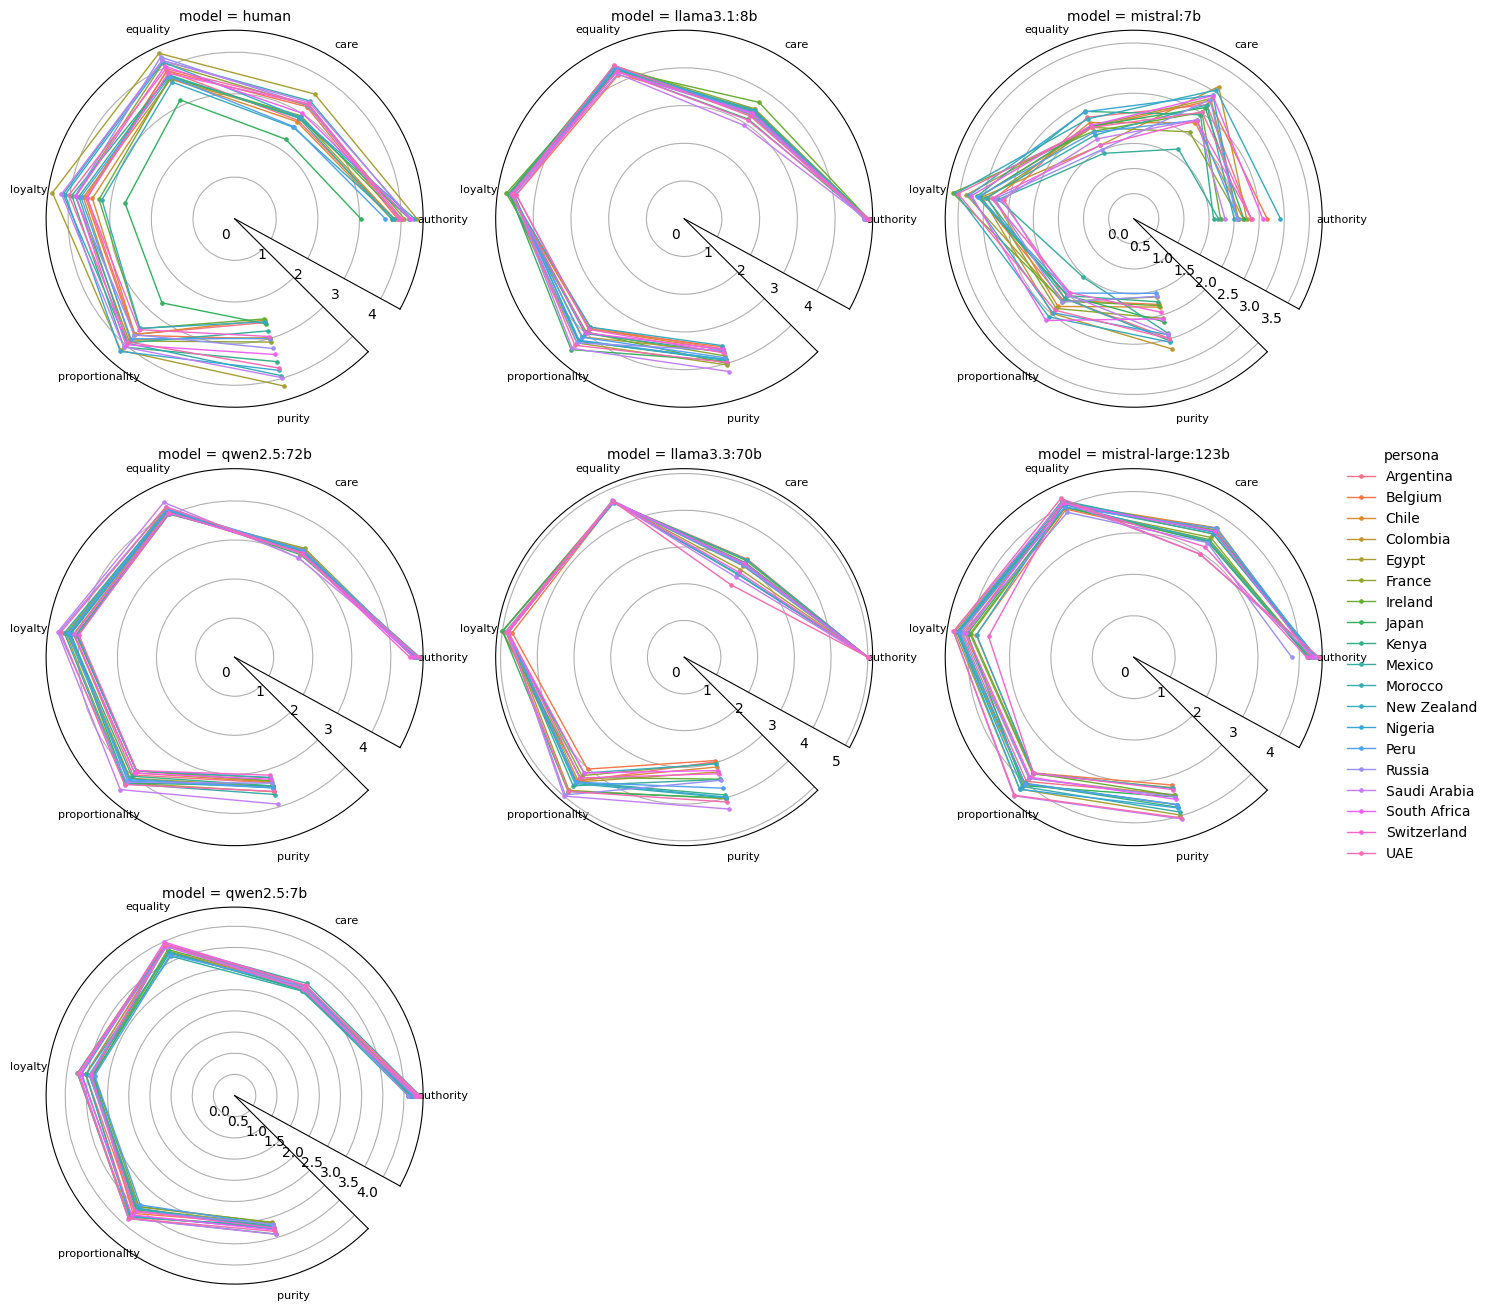

In [11]:
grid = seaborn.FacetGrid(
    df_prep, 
    col="model",
    col_wrap=3,
    hue="persona",
    height=4.5,
    sharex=False, 
    sharey=False, 
    despine=False,
    subplot_kws=dict(projection='polar'),
)

grid.map(
    seaborn.pointplot, 
    "dimension_projection", 
    "response",
    lw=1
)

grid.add_legend()

for ax in grid.axes.flat:
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8)

grid.savefig("reports/polar.dimensions.by_model.pdf")
